# Training a neural network on MNIST with Keras

**This example is based on the following Tensorflow tutorial**  
Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0  
Modifications by Georg Zitzlsberger (<georg.zitzlsberger@vsb.cz>)  
  
The original example is available here:
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>  

## Step 0: Setup environment

- Set the GPU(s) to use
- Optional: Tuning knowbs for CPU only execution
- Show available devices for computation
- Use Tensorflow 2.0 semantic

In [1]:
import os
import tensorflow as tf
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

#NUM_PARALLEL_EXEC_UNITS=10
#tf.config.threading.set_intra_op_parallelism_threads(NUM_PARALLEL_EXEC_UNITS)
#tf.config.threading.set_inter_op_parallelism_threads(1)
#tf.config.set_soft_device_placement(True)

#os.environ["OMP_NUM_THREADS"] = "{}".format(NUM_PARALLEL_EXEC_UNITS)
#os.environ["KMP_BLOCKTIME"] = "30"
#os.environ["KMP_SETTINGS"] = "1"
#os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

#physical_devices = tf.config.experimental_list_devices() # Only for TF 2.0
physical_devices = tf.config.list_physical_devices() # For TF >= 2.1
print(physical_devices)

tfds.disable_progress_bar()
tf.enable_v2_behavior()

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available: ", len(gpus))
local_gpu =  0 # Only using one right now
if gpus:
    try:
        tf.config.set_visible_devices(gpus[local_gpu], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4ro2xui4 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs available:  2


## Step 1: Create your input pipeline

Build efficient input pipeline using advices from:
* [TFDS performance guide](https://www.tensorflow.org/datasets/performances)
* [tf.data performance guide](https://www.tensorflow.org/guide/data_performance#optimize_performance)


### Load MNIST

Load with the following arguments:

* `shuffle_files`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised`: Returns tuple `(img, label)` instead of dict `{'image': img, 'label': label}`

In [2]:
# used to disable (lack of) https warning
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train.apply(tf.data.experimental.assert_cardinality(ds_info.splits['train'].num_examples))
ds_test.apply(tf.data.experimental.assert_cardinality(ds_info.splits['test'].num_examples))

<_AssertCardinalityDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

### Build training pipeline

Apply the following transormations:

* `ds.map`: TFDS provide the images as tf.uint8, while the model expect tf.float32, so normalize images
* `ds.cache` As the dataset fit in memory, cache before shuffling for better performance.<br/>
__Note:__ Random transformations should be applied after caching
* `ds.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For bigger datasets which do not fit in memory, a standard value is 1000 if your system allows it.
* `ds.batch`: Batch after shuffling to get unique batches at each epoch.
* `ds.prefetch`: Good practice to end the pipeline by prefetching [for performances](https://www.tensorflow.org/guide/data_performance#prefetching).

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# Extend ds_train to:
# 1. use normalize_img via map
# 2. cache
# 3. shuffle # of ds_info.splits['train'].num_examples
# 4. batch with a batch size of 128
# 5. prefetch
ds_train = ds_train.???

### Inspect the data set

Display individual MNIST samples and their labels.

**Note:** Rerun the cell to see different samples. This is due to shuffling of the data in the 'ds_train' dataset every time it is accessed (iterated).

#### **Label:** 1

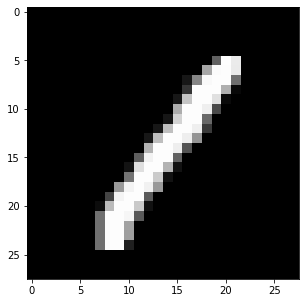

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Show one image in ds_train (Note that rerunning reshuffles!)
batch = 40 # Can be any batch
idx = 40   # Can be any index within each batch
for x, y in ds_train:
    if batch == 0:
        img = x[idx][:, :,0]
        img = np.stack((img,)*3, axis=-1)
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        display(Markdown("#### **Label:** {}".format(y[idx])))
        plt.show()
        break
    else:
        batch -= 1

### Build evaluation pipeline

Testing pipeline is similar to the training pipeline, with small differences:

 * No `ds.shuffle()` call
 * Caching is done after batching (as batches can be the same between epoch)

In [6]:
# Extend ds_test to:
# 1. use normalize_img via map
# 2. batch with a batch size of 128
# 3. cache
# 4. prefetch
ds_test = ds_test.???